In [1]:
from functools import cached_property
from mlflux.predictor import FluxANNs
import torch
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from mlflux.datafunc import data_split_psd
from mlflux.ann import RealFluxDataset

%load_ext autoreload
%autoreload 3

In [3]:
psd = xr.load_dataset('../../data/Processed/psd_wave.nc')

# 77, 69, 83, 78, 87, 72, 71, 68, 67, 73
split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]]
split2 = [[77, 83, 78, 87, 72, 71, 68, 67, 73], [69], [69]]
split3 = [[77, 69, 78, 87, 72, 71, 68, 67, 73], [83], [83]]
split4 = [[77, 69, 83, 78, 68, 67, 73], [87, 72, 71], [87, 72, 71]]
split5 = [[77, 69, 83, 78, 87, 72, 71, 67, 73], [68], [68]]
split6 = [[77, 69, 83, 68, 87, 72, 71], [78, 67, 73], [78, 67, 73]]
split_ensem = [split1, split2, split3, split4, split5, split6]

In [9]:
''' Predictor with four inputs and four outputs '''
class Flux41(FluxANNs):
    
    @cached_property
    def Xscale(self):
        # mean of x1, mean of x2
        mean = torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32'))
        # std of x1, std of x2 (or scale)
        scale = torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([0]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([0.1]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
    
    def evaluate_uniform(self):
        pass

''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff   
class Flux41diff(Flux41):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)  

In [10]:
''' Momentum flux models '''
momentum_model_ensem = []

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    okeys = ['taucx']
    bkeys = ['taubx']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

    ###### Run the model 5 times ###### 
    model = Flux41diff({'mean_ann_para':para1, 'var_ann_para':para2})
    model.datasplit = split
    training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2,
                      'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
    log = model.fit(training_data,validating_data,training_paras,VERBOSE=False)
    momentum_model_ensem.append(model)
    # Later we can pick one before saving but since files are pretty small they are ok 
    # model.save(fname="../../saved_model/full_anns_diff_3layers_split%g" %(i+1))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068


/Users/jwu/miniconda3/envs/mlflux/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 294 epochs.
training took 23.27 seconds, loss at last epoch -49.9855
Training samples: 8463
Validating samples: 1610
Testing samples: 1610


/Users/jwu/miniconda3/envs/mlflux/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 203 epochs.
training took 17.38 seconds, loss at last epoch -56.1355
Training samples: 7424
Validating samples: 2649
Testing samples: 2649


/Users/jwu/miniconda3/envs/mlflux/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 199 epochs.
training took 15.14 seconds, loss at last epoch -60.4006
Training samples: 9194
Validating samples: 879
Testing samples: 879


/Users/jwu/miniconda3/envs/mlflux/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 375 epochs.
training took 35.27 seconds, loss at last epoch -57.8634
Training samples: 8826
Validating samples: 1247
Testing samples: 1247


/Users/jwu/miniconda3/envs/mlflux/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 115 epochs.
training took 10.06 seconds, loss at last epoch -40.6258
Training samples: 9453
Validating samples: 620
Testing samples: 620


/Users/jwu/miniconda3/envs/mlflux/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 147 epochs.
training took 13.81 seconds, loss at last epoch -54.5558


In [ ]:
''' Sensible flux models '''
Qs_model_ensem = []

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    okeys = ['hsc']
    bkeys = ['hsb']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

    ###### Run the model 5 times ###### 
    model = Flux41diff({'mean_ann_para':para1, 'var_ann_para':para2})
    model.datasplit = split
    training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2,
                      'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
    log = model.fit(training_data,validating_data,training_paras,VERBOSE=False)
    Qs_model_ensem.append(model)
    # Later we can pick one before saving but since files are pretty small they are ok 
    # model.save(fname="../../saved_model/full_anns_diff_3layers_split%g" %(i+1))

In [ ]:
''' Latent flux models '''
Ql_model_ensem = []

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    okeys = ['hlc']
    bkeys = ['hlb']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

    ###### Run the model 5 times ###### 
    model = Flux41diff({'mean_ann_para':para1, 'var_ann_para':para2})
    model.datasplit = split
    training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2,
                      'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
    log = model.fit(training_data,validating_data,training_paras,VERBOSE=False)
    Ql_model_ensem.append(model)
    # Later we can pick one before saving but since files are pretty small they are ok 
    # model.save(fname="../../saved_model/full_anns_diff_3layers_split%g" %(i+1))

In [20]:
''' Testing '''
def mse_r2(ypred, ytruth):
    ''' Assuming Nsample*Nfeatures. Change this to just keeping the last axis. '''
    mse = np.average((ypred-ytruth)**2, axis=0)
    r2 = 1 - np.average((ypred-ytruth)**2, axis=0)/np.var(ytruth, axis=0)
    return (mse,r2)

def evaluate_over_splits (model, keys):
    nn_r2_splits = []; bulk_r2_splits = []
    for i in range(6):
        training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split_ensem[i], PLOT=False, XVIS='samples', VERBOSE=False)
        vd = RealFluxDataset(training_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
        scores = model.metrics(vd.X, vd.Y)    
        bulk_mse, bulk_r2 = mse_r2(vd.Bulk.detach().numpy(), vd.Y.detach().numpy())
        nn_r2_splits.append(scores['r2']); bulk_r2_splits.append(bulk_r2)
    return (np.array(nn_r2_splits).squeeze(), np.array(bulk_r2_splits).squeeze())
        # print('NN r2 %.4f, bulk r2 %.4f' %(scores['r2'], bulk_r2))

In [21]:
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
for model in momentum_model_ensem:
    model.nn_r2_splits, model.bulk_r2_splits = evaluate_over_splits(model, keys)
    print(model.nn_r2_splits, model.bulk_r2_splits)

[0.800586   0.83716357 0.85131407 0.80733216 0.81876504 0.8269768 ] [0.7882633  0.8452643  0.86462414 0.81711197 0.8268765  0.8362277 ]
[0.79365724 0.83413196 0.8476044  0.8085647  0.8162339  0.82472193] [0.7882633  0.8452643  0.86462414 0.81711197 0.8268765  0.8362277 ]
[0.7853234  0.83207357 0.8493099  0.80674505 0.8144113  0.8219383 ] [0.7882633  0.8452643  0.86462414 0.81711197 0.8268765  0.8362277 ]
[0.78960156 0.83667463 0.8516655  0.8130681  0.8193831  0.82719296] [0.7882633  0.8452643  0.86462414 0.81711197 0.8268765  0.8362277 ]
[0.7913508  0.83424455 0.8482119  0.8089639  0.81957495 0.8247812 ] [0.7882633  0.8452643  0.86462414 0.81711197 0.8268765  0.8362277 ]
[0.7952812  0.841316   0.85654676 0.81497455 0.8231603  0.8319459 ] [0.7882633  0.8452643  0.86462414 0.81711197 0.8268765  0.8362277 ]


(0.6, 1.0)

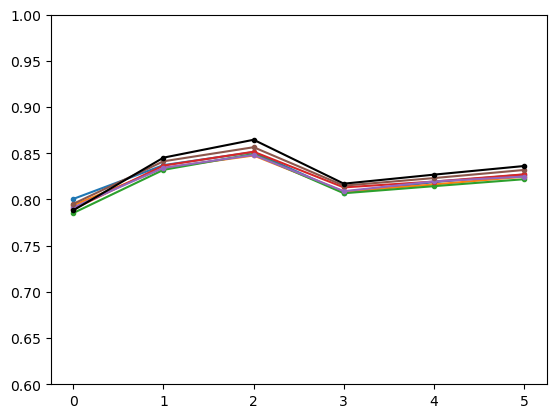

In [29]:
for model in momentum_model_ensem:
    plt.plot(model.nn_r2_splits,'.-')
plt.plot(model.bulk_r2_splits,'.-', c='k')
plt.ylim([0.6,1])